In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", 50)


Import

In [198]:
# Import
df = pd.read_csv('../data/train.csv')

#Drop obivious bad columns
cols_to_drop = ['regio1', 'geo_bln', 'houseNumber', 'geo_krs', 'street', 'streetPlain', 'regio2', 'regio3', 'description', 'facilities', 'date', 'yearConstructedRange', 'baseRentRange', 'noRoomsRange', 'livingSpaceRange']

df = df.drop(columns=cols_to_drop)

df

,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,cellar,baseRent,livingSpace,condition,interiorQual,petsAllowed,lift,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,garden,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,americanArea
0,235.00,central_heating,NaN,NaN,False,True,8,5.13,NaN,NaN,1978.0,110401882,NaN,oil,False,True,695.0,100.00,well_kept,NaN,no,False,apartment,48157,2.0,162.0,NaN,NaN,False,NaN,F,NaN,NaN,NaN,1076.390000
1,180.00,heat_pump,NaN,NaN,True,True,18,4.98,NaN,NaN,2018.0,113246709,1.0,electricity,False,True,1010.0,87.56,first_time_use,sophisticated,NaN,True,apartment,48167,3.0,14.0,1.0,1.0,True,80.0,A_PLUS,NaN,NaN,NaN,942.487084
2,140.00,gas_heating,ONE_YEAR_FREE,NaN,False,True,6,6.67,40.0,NaN,1974.0,106998808,NaN,gas,False,True,669.0,76.75,fully_renovated,normal,negotiable,True,apartment,48159,3.0,201.0,1.0,11.0,False,90.0,NaN,NaN,90.76,0.1915,826.129325
3,180.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,False,1,6.93,10.0,NaN,1870.0,107382376,NaN,gas,False,True,731.5,77.00,NaN,normal,no,False,apartment,48151,2.0,NaN,1.0,NaN,False,NaN,NaN,2013.0,90.76,0.1915,828.820300
4,170.00,NaN,ONE_YEAR_FREE,NaN,True,True,19,6.81,40.0,NaN,2018.0,107298660,1.0,NaN,False,False,990.0,85.00,mint_condition,sophisticated,NaN,False,apartment,48155,3.0,NaN,1.0,NaN,False,NaN,NaN,NaN,90.76,0.1915,914.931500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,160.00,floor_heating,NaN,NaN,False,True,12,4.89,NaN,1090.00,2017.0,100729298,1.0,geothermal,False,True,930.0,81.00,mint_condition,luxury,no,False,ground_floor,48165,3.0,NaN,0.0,3.0,False,NaN,NaN,NaN,NaN,NaN,871.875900
342,440.00,district_heating,ONE_YEAR_FREE,10.0,False,True,11,4.50,10.0,2425.00,2013.0,112229750,1.0,district_heating,False,True,1985.0,147.00,NaN,NaN,NaN,True,apartment,48143,3.0,80.0,0.0,2.0,False,NaN,NaN,NaN,NaN,NaN,1582.293300
343,315.00,central_heating,ONE_YEAR_FREE,NaN,False,True,19,6.17,40.0,1756.00,1992.0,102258247,1.0,gas,False,True,1426.0,142.60,fully_renovated,sophisticated,negotiable,False,ground_floor,48161,4.0,139.0,0.0,3.0,True,NaN,NaN,2020.0,NaN,NaN,1534.932140
344,513.04,district_heating,ONE_YEAR_FREE,NaN,True,True,2,4.90,40.0,1853.04,2020.0,115573239,1.0,district_heating,True,False,1340.0,134.00,first_time_use,sophisticated,no,True,apartment,48151,4.0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,1442.362600


Fill Target values

In [199]:
df['totalRent'].isna().sum()

np.int64(133)

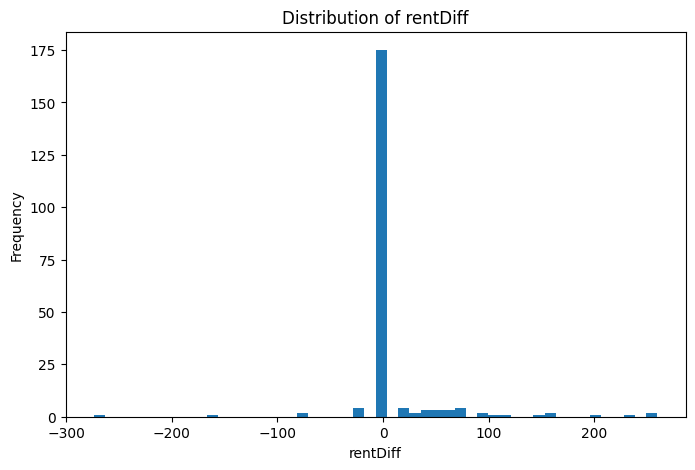

In [200]:
# Durch baseRent + serviceCharge + heatingCosts lässt sich die totalRent relativ gut erklären
df['rentDiff'] = df['totalRent'] - df['baseRent'] - df['serviceCharge'].fillna(0) - df['heatingCosts'].fillna(0)
plt.figure(figsize=(8,5))
plt.hist(df["rentDiff"].dropna(), bins=50)
plt.xlabel("rentDiff")
plt.ylabel("Frequency")
plt.title("Distribution of rentDiff")
plt.show()

df = df.drop(columns=['rentDiff'])

In [201]:
#Auffüllen der Target Werte
df['totalRent'] = df['totalRent'].fillna(df['baseRent'] + df['serviceCharge'].fillna(0) + df['heatingCosts'].fillna(0))

# Delete baseRent, serviceCharge, heatingCosts
df = df.drop(columns=['baseRent', 'serviceCharge', 'heatingCosts'])

Cleaning data

In [202]:
def col_encoder(df: pd.DataFrame, col: str) -> tuple[pd.DataFrame, dict]:
    df[col], mapping = pd.factorize(df[col])

    return df, dict(enumerate(mapping))

In [203]:
df_cols_nono_num = df.select_dtypes(exclude='number').columns.to_list()

In [204]:
dict_of_mappings = {}

for col in df_cols_nono_num:
    df, mapping = col_encoder(df, col)
    dict_of_mappings[col] = mapping   

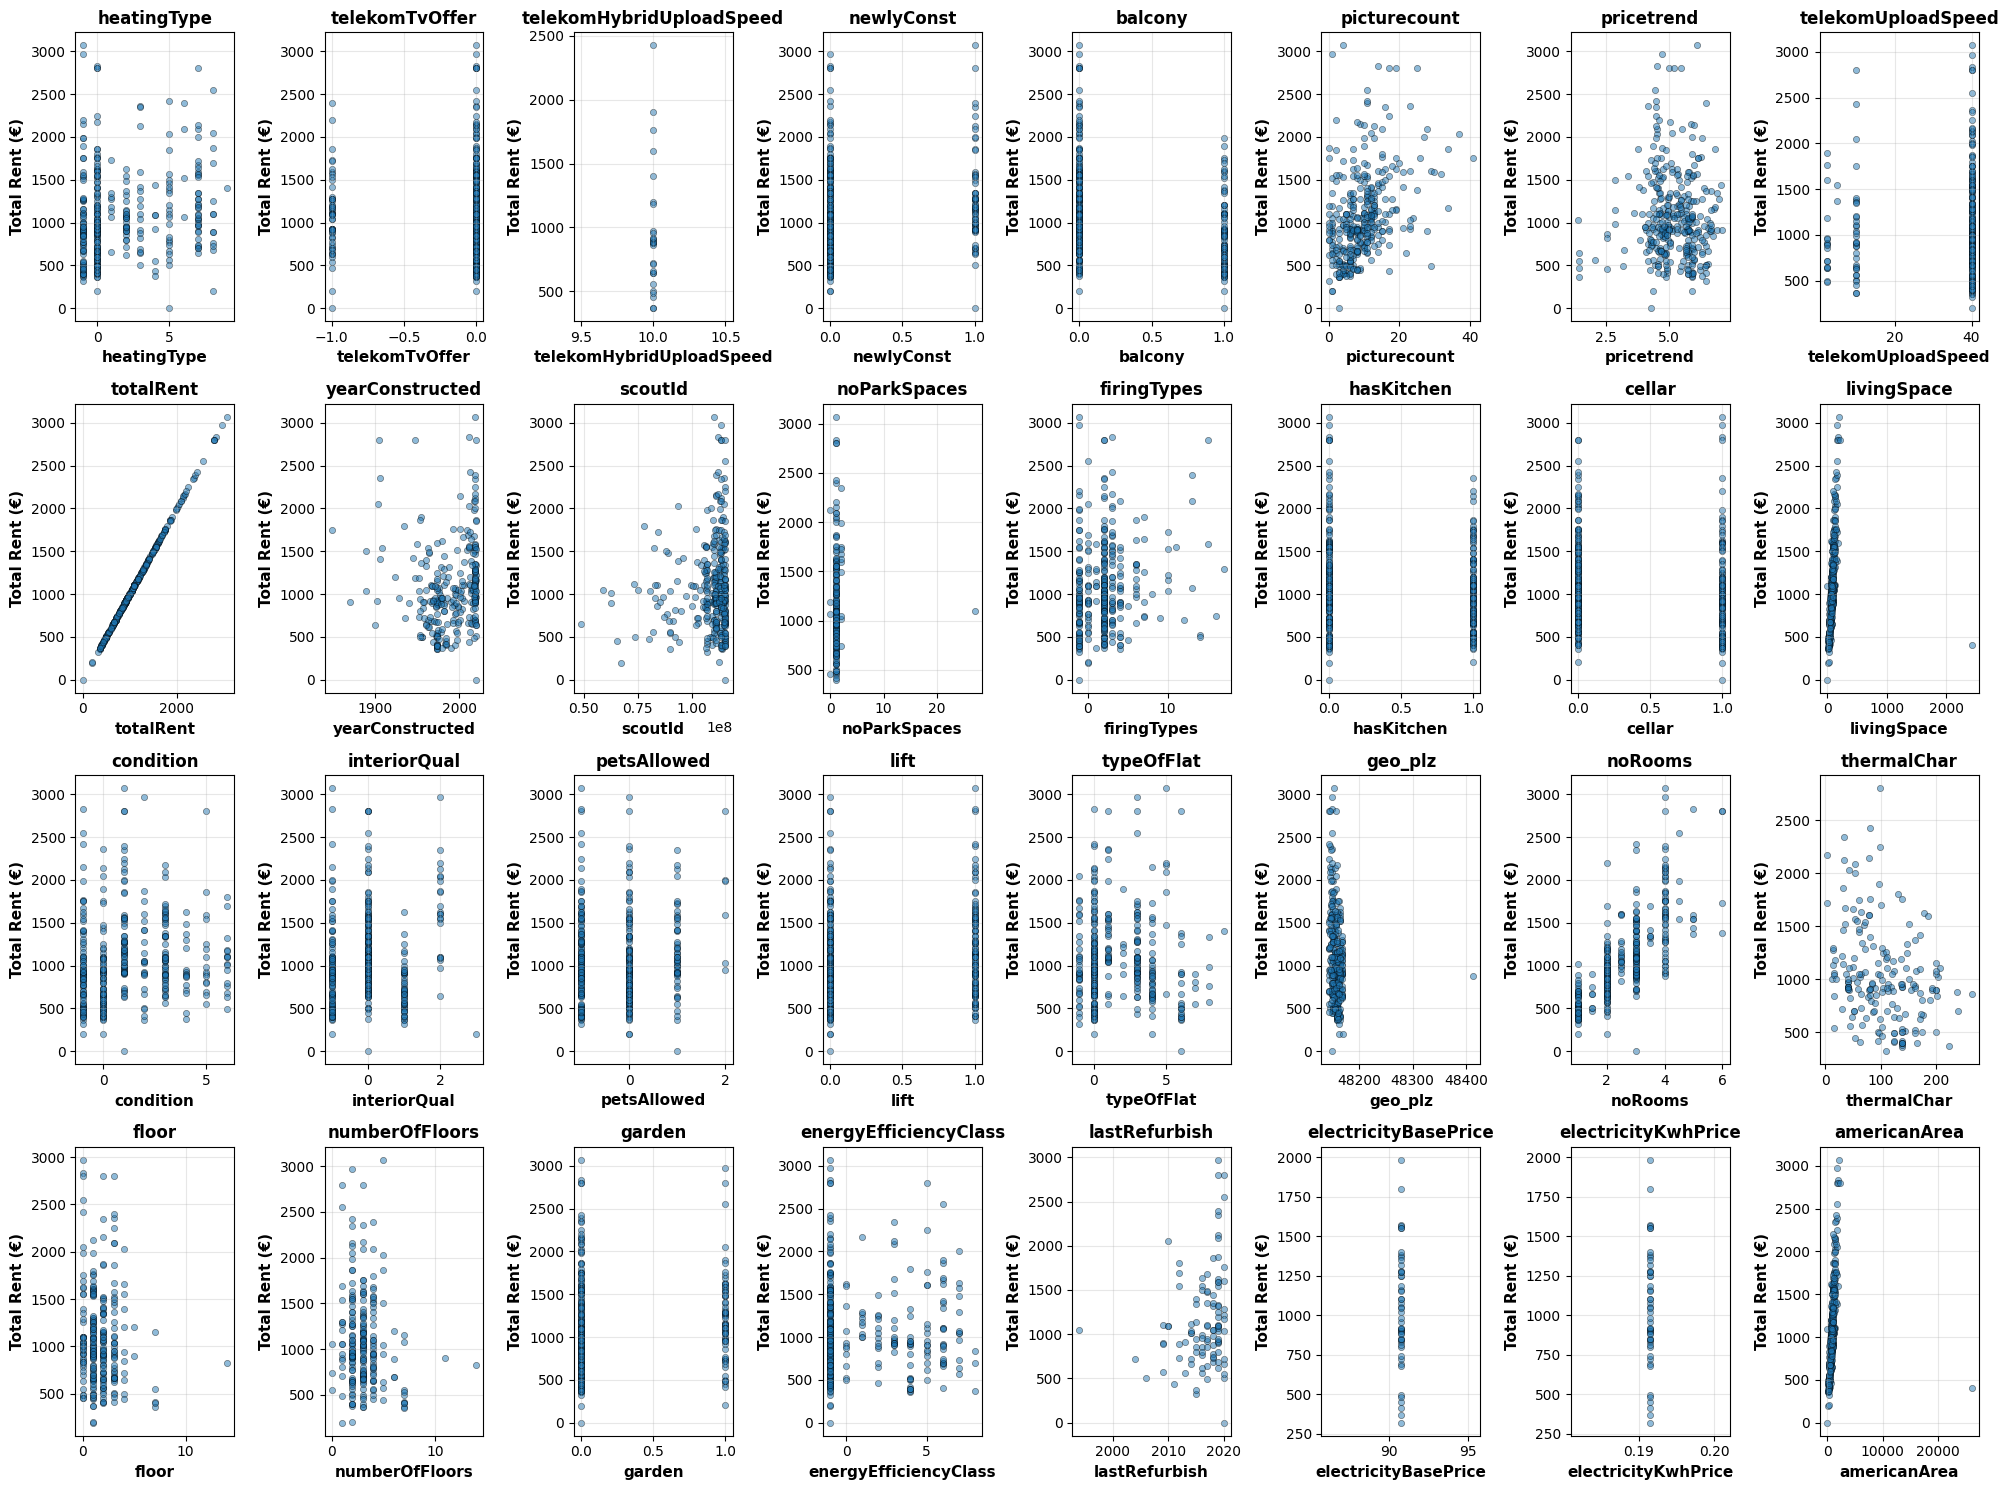

In [205]:
import matplotlib.pyplot as plt

# Select numerical features for visualization
#numerical_features = df.select_dtypes(include='number').columns.to_numpy()


def plot_scatter_matrix(df: pd.DataFrame, df_cols: list[str], target: str) -> None:
    # Create a grid of scatter plots
    fig, axes = plt.subplots(4, 8, figsize=(20, 15))
    axes = axes.flatten()

    for i, feature in enumerate(df_cols):
        ax = axes[i]
        
        # Create scatter plot
        ax.scatter(df[feature], df[target], alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
        ax.set_xlabel(feature, fontsize=11, fontweight='bold')
        ax.set_ylabel('Total Rent (€)', fontsize=11, fontweight='bold')
        ax.set_title(feature, fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

df_cols = df.columns.to_list()
target = 'totalRent'
plot_scatter_matrix(df, df_cols, target)

Remove Outliers:

In [206]:
# Drop pictures outliers
len_df = len(df)
df = df[~((df['totalRent'] >= 2700) & (df['picturecount'] <= 5))]
print(f'Length after picturecount filter: {len(df)} , dropped: {len_df - len(df)}')

# Drop noParkSpaces outliers
len_df = len(df)
df = df[~(df['noParkSpaces'] > 10)]
print(f'Length after noParkSpaces filter: {len(df)}, dropped: {len_df - len(df)}')

# Drop livingSpace outliers
len_df = len(df)    
df = df[~((df['livingSpace'] > 2000) | (df['livingSpace'] < 10))]
print(f'Length after livingSpace filter: {len(df)}, dropped: {len_df - len(df)}')

# Drop geo_plz outliers
len_df = len(df)
df = df[~(df['geo_plz'] > 48400)]
print(f'Length after geo_plz filter: {len(df)} , dropped: {len_df - len(df)}')

# Drop number of floors outliers
len_df = len(df)
df = df[~(df['numberOfFloors'] > 10)]
print(f'Length after numberOfFloors filter: {len(df)}, dropped: {len_df - len(df)}')

# Drop lastRefurbish
len_df = len(df)
df = df[~(df['lastRefurbish'] < 2000)]
print(f'Length after lastRefurbish filter: {len(df)}, dropped: {len_df - len(df)}')

# Drop americaanArea outliers
len_df = len(df)
df = df[~(df['americanArea'] > 10000)]
print(f'Length after americanArea filter: {len(df)}, dropped: {len_df - len(df)}')

Length after picturecount filter: 344 , dropped: 2
Length after noParkSpaces filter: 343, dropped: 1
Length after livingSpace filter: 340, dropped: 3
Length after geo_plz filter: 339 , dropped: 1
Length after numberOfFloors filter: 337, dropped: 2
Length after lastRefurbish filter: 336, dropped: 1
Length after americanArea filter: 336, dropped: 0


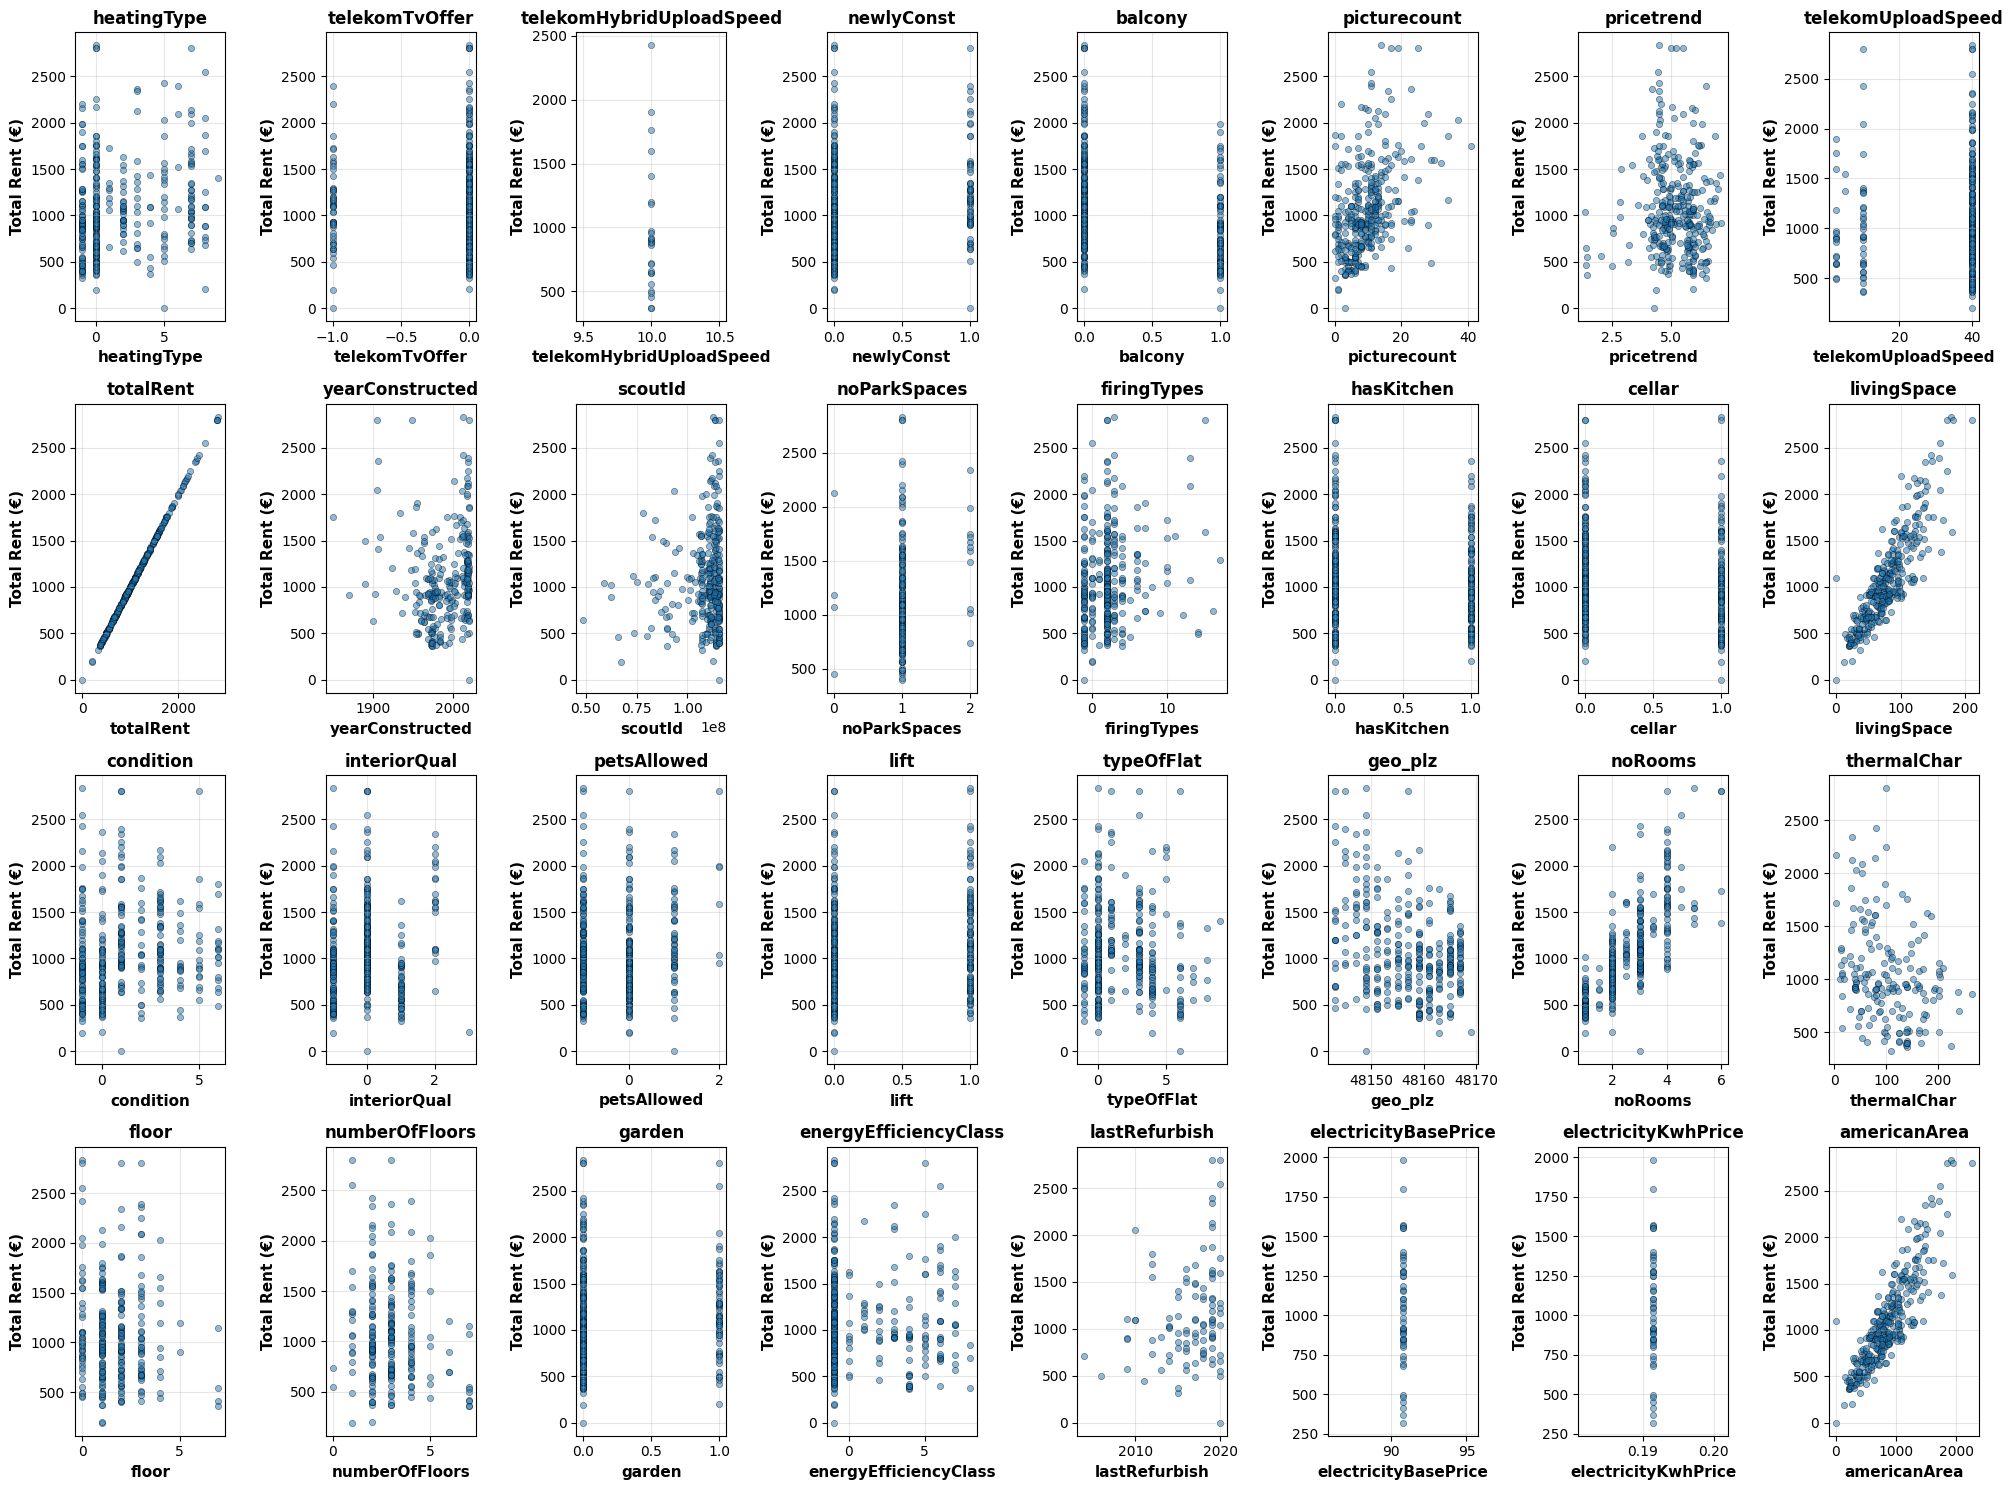

In [179]:
plot_scatter_matrix(df, df_cols, target)

Correlation


In [180]:
corr_matrix = df.corr()
corr_to_total_rent = corr_matrix['totalRent'].sort_values(ascending=False).drop('totalRent')
corr_to_total_rent

livingSpace                 0.877858
americanArea                0.877858
noRooms                     0.758520
picturecount                0.430715
lastRefurbish               0.235087
heatingType                 0.214786
firingTypes                 0.179360
newlyConst                  0.172513
noParkSpaces                0.156671
lift                        0.152968
interiorQual                0.140715
garden                      0.132254
condition                   0.119601
petsAllowed                 0.116046
scoutId                     0.102901
yearConstructed             0.069435
telekomUploadSpeed          0.032985
energyEfficiencyClass       0.016947
pricetrend                 -0.006723
telekomTvOffer             -0.017760
typeOfFlat                 -0.064312
floor                      -0.080611
hasKitchen                 -0.114649
numberOfFloors             -0.139926
cellar                     -0.183379
thermalChar                -0.294653
balcony                    -0.301035
g

In [181]:
# Filter for top features based on correlation coefficient threshold
corralation_coeff_threshold = 0.1

top_features = corr_to_total_rent[corr_to_total_rent.abs() > corralation_coeff_threshold].index.tolist()
top_features

['livingSpace',
 'americanArea',
 'noRooms',
 'picturecount',
 'lastRefurbish',
 'heatingType',
 'firingTypes',
 'newlyConst',
 'noParkSpaces',
 'lift',
 'interiorQual',
 'garden',
 'condition',
 'petsAllowed',
 'scoutId',
 'hasKitchen',
 'numberOfFloors',
 'cellar',
 'thermalChar',
 'balcony',
 'geo_plz']

Feature Selection

In [182]:
# Looking at missing values in top features
final_cols = top_features + ['totalRent']

df = df[final_cols]
df.isna().sum()

livingSpace         0
americanArea        0
noRooms             0
picturecount        0
lastRefurbish     236
heatingType         0
firingTypes         0
newlyConst          0
noParkSpaces      162
lift                0
interiorQual        0
garden              0
condition           0
petsAllowed         0
scoutId             0
hasKitchen          0
numberOfFloors    115
cellar              0
thermalChar       156
balcony             0
geo_plz             0
totalRent           0
dtype: int64

In [183]:
# Removing features with many missing values
final_cols = [feature for feature in final_cols if feature not in ['lastRefurbish', 'noParkSpaces', 'numberOfFloors', 'thermalChar']]
df[final_cols].isna().sum()

livingSpace     0
americanArea    0
noRooms         0
picturecount    0
heatingType     0
firingTypes     0
newlyConst      0
lift            0
interiorQual    0
garden          0
condition       0
petsAllowed     0
scoutId         0
hasKitchen      0
cellar          0
balcony         0
geo_plz         0
totalRent       0
dtype: int64

In [184]:
df_final = df[final_cols]

In [185]:
df_final

,livingSpace,americanArea,noRooms,picturecount,heatingType,firingTypes,newlyConst,lift,interiorQual,garden,condition,petsAllowed,scoutId,hasKitchen,cellar,balcony,geo_plz,totalRent
0,100.00,1076.390000,2.0,8,0,0,0,0,-1,0,0,0,110401882,0,0,0,48157,930.00
1,87.56,942.487084,3.0,18,1,1,1,1,0,1,1,-1,113246709,0,0,0,48167,1270.00
3,77.00,828.820300,2.0,1,3,2,0,0,1,0,-1,0,107382376,0,0,1,48151,911.50
4,85.00,914.931500,3.0,19,-1,-1,1,0,0,0,3,-1,107298660,0,1,0,48155,1160.00
5,75.00,807.292500,2.0,28,-1,0,0,0,-1,0,-1,-1,111158701,0,1,1,48161,900.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,81.00,871.875900,3.0,12,7,6,0,0,2,0,3,0,100729298,0,0,0,48165,1090.00
342,147.00,1582.293300,3.0,11,5,3,0,1,-1,0,-1,-1,112229750,0,0,0,48143,2425.00
343,142.60,1534.932140,4.0,19,0,2,0,0,0,1,2,1,102258247,0,0,0,48161,1756.00
344,134.00,1442.362600,4.0,2,5,3,1,1,0,0,1,0,115573239,1,1,0,48151,1853.04


In [ ]:
from src.baseline_model import BaselineModel, train_baseline_model, evaluate_model



ModuleNotFoundError: No module named 'src'